**INTRODUCTION**

This project required the construction and comparison of multiple RNN (recurrent Neural Network) models to classify tweets based on if their text indicates a disaster or not based on the text of the tweet. This project will not only require RNN modeling construction, but also some natural language processing (NLP) understanding. Ultimately, this is a binary classification project using a known sequence of data - each tweet. This set up makes it ideal for an RNN approach.

The dataset incluse 7,613 tweets in the training set and 3,263 tweets in the testing set. The tweets are of varying lengths. 

**DATA AND PACKAGE LOADING**

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [88]:
directory = '/kaggle/input/nlp-getting-started'

train_path = directory + '/train.csv'
train_df = pd.read_csv(train_path)

test_path = directory + '/test.csv'
test_df = pd.read_csv(test_path)


In [89]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [90]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**DATA CLEANING AND EXPLORATORY DATA ANALYSIS**

First, the columns with NAs were removed. The location and keyword columns don't provide much additional information. It will be the text itself which provides the means to predict a disaster.

Then, the length of each tweet was calculated for some further exploration in both the training and testing data. Immediately noticeable is the one outlier in both sets. While extreme in the training data, it is only slightly an outlier in the testing data. At first look, both sets had remarkably similar means and standard deviations but looking further revealed that the two sets are similar is every other metric as well. Certaininly, the training and testing sets can be considered similar. Ultimately, this will hopefully provide similarly suitable data for the best modeling and then predictions based on comparable inputs. The boxplots below confirm this

For the training set, the breakdown of disaster and non-disaster tweet were not even, but were also not too far imbalanced. This should provided suitable data for training out model.

In [91]:
train_df = train_df[['id','text','target']]
train_df['length'] = [len(x.split(' ')) for x in train_df['text']]
train_df.head()

,id,text,target,length
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


In [92]:
train_df['length'].describe()

count    7613.000000
mean       14.928937
std         5.782770
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: length, dtype: float64

<Axes: ylabel='count'>

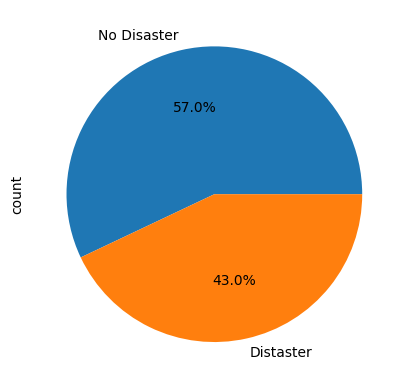

In [93]:
labels = {1:'Distaster', 0:"No Disaster"}
dat = train_df.target.map(labels).value_counts()

dat.plot.pie(autopct='%1.1f%%')
    

In [94]:
test_df['length'] = [len(x.split(' ')) for x in test_df['text']]
test_df.head()

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8


In [95]:
test_df['length'].describe()

count    3263.000000
mean       14.978854
std         5.814619
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        34.000000
Name: length, dtype: float64

<Axes: >

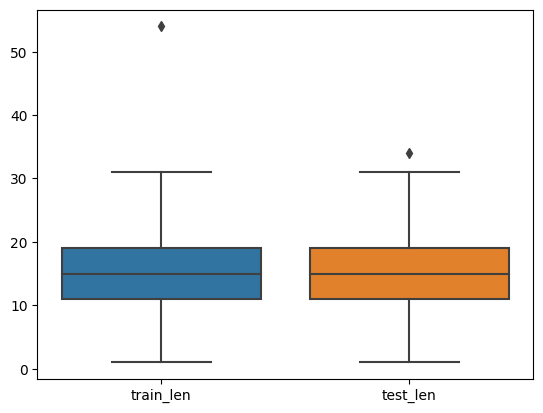

In [96]:
lengths = pd.DataFrame({'train_len':train_df['length'],
                       'test_len':test_df['length']})
sns.boxplot(data = lengths)

**MODEL CONSTRUCTION AND ARCHITECTURE**

The number of unique words for the training and testing datasets gives an idea of the total number of unique words for the two vocabularies. This informs the vocabulary size with the encoder.

Some language processing is necessary in order clean up unneeded stop word, characters, and the like.

The training data is split into training and validation sets for the model learning and subsequent validation. Before it can be fed into the model, the data needs to be converted into a tensorflow dataset from a pandas dataframe.

Two models were created, one using a long-short term memory (LTSM) architecture aimed at resolving the vanishing-gradient problem associated with recurrent neural networks and the other using a gated recurrent unit (GRU) set up. While similar, the GRU model is architecturally simpler due to the structure of the unit itself since it lacks a context vector as well as an output gate present in LSTM structures. Both models have early stopping built in. This item monitors the loss associated with the validation set, identifies the minimal loss value and the epoch where it occurs, and then has patience for 5 additional epochs after the minimal loss in order to see if the loss improves. Most importantly, it records the parameters associated with the optimal performace, saving them for future use.




In [97]:
#source: https://levelup.gitconnected.com/painless-classification-model-using-rnn-b90cb0982543

from nltk import word_tokenize

data = train_df['text'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in data for word in tweet)  # set created from nested comprehension 
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(data)))

There are 23212 unique words in the dataset.
There are 7613 unique tweets in the dataset.


In [98]:
#source: https://medium.com/@pawan329/text-data-preprocessing-made-#easy-steps-to-clean-text-data-using-python-81a138a0e0e3

import re
import string
import nltk.corpus
import nltk.stem
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    return tokens

def remove_stop(tokens):
    stops = set(stopwords.words('english'))
    filt_tok = [word for word in tokens if word not in stops]
    return filt_tok

#def lemmatizations(tokens):
 #   lem = WordNetLemmatizer()
  #  lem_toks = [lem.lemmatize(token) for token in tokens]
   # return lem_toks

def cleaner_fxn(text):
    tokens = preprocess(text)
    filtered_toks = remove_stop(tokens)
    #lem_toks = lemmatizations(filtered_toks)
    clean_txt = " ".join(filtered_toks)
    return clean_txt

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
test_df = test_df[['id','text']]

data_test = test_df['text'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in data_test for word in tweet)  # set created from nested comprehension 
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(data)))

There are 12977 unique words in the dataset.
There are 7613 unique tweets in the dataset.


In [100]:
print(train_df['text'][0])
cleaner_fxn(train_df['text'][0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


'deeds reason earthquake may allah forgive us'

In [101]:
train_df['text'] = [cleaner_fxn(train_df['text'][i]) for i in range(len(train_df))]
train_df.head()

,id,text,target,length
0,1,deeds reason earthquake may allah forgive us,1,13
1,4,forest fire near la ronge sask canada,1,7
2,5,residents asked shelter place notified officer...,1,22
3,6,people receive wildfires evacuation orders cal...,1,9
4,7,got sent photo ruby alaska smoke wildfires pou...,1,17


In [102]:
test_df['text'] = [cleaner_fxn(test_df['text'][i]) for i in range(len(test_df))]
test_df.head()

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different cities stay safe ev...
2,3,forest fire spot pond geese fleeing across str...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills china taiwan


In [86]:
train_data, val_data = train_test_split(train_df, test_size = 0.2, random_state = 0)

In [103]:
#turn dataframe into tensorflow dataset.  Source: https://medium.com/
#when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168
features = 'text'

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_data[features].values, tf.string),
            tf.cast(train_data['target'].values, tf.int32))))

val_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(val_data[features].values, tf.string),
            tf.cast(val_data['target'].values, tf.int32))))

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_df['text'].values, tf.string))))

In [104]:
BUFFER_SIZE = 10000
BATCH_SIZE = 10

training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [105]:
VOCAB_SIZE = 25000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [106]:
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=5, restore_best_weights=True)

lr = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = 0.00005,
      decay_steps = 1000,
      decay_rate=0.9) 

In [107]:
#Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])


In [108]:
history = model.fit(training_dataset, epochs=100,
                    validation_data=val_dataset,
                   callbacks=early_stopping)

Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.5726 - loss: 1.2933 - val_accuracy: 0.6120 - val_loss: 0.6542
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6149 - loss: 0.6524 - val_accuracy: 0.7177 - val_loss: 0.5881
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.7615 - loss: 0.5154 - val_accuracy: 0.7728 - val_loss: 0.5310
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8685 - loss: 0.3401 - val_accuracy: 0.7879 - val_loss: 0.6017
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9162 - loss: 0.2573 - val_accuracy: 0.7873 - val_loss: 0.7279
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9541 - loss: 0.1846 - val_accuracy: 0.7886 - val_loss: 0.8181
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9606 - loss: 0.1574 - val_accuracy: 0.7873 - val_loss: 0.8606
Epoch 8/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9689 - loss: 0

In [111]:
val_loss, val_acc = model.evaluate(val_dataset)

print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7790 - loss: 0.5162
Validation Loss: 0.5310117602348328
Validation Accuracy: 0.7728168368339539


In [112]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [113]:
history2 = model2.fit(training_dataset, epochs=100,
                    validation_data=val_dataset,
                   callbacks=early_stopping)

Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5791 - loss: 1.5184 - val_accuracy: 0.5817 - val_loss: 0.8170
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.5793 - loss: 0.7491 - val_accuracy: 0.5817 - val_loss: 0.6642
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.6165 - loss: 0.6516 - val_accuracy: 0.6356 - val_loss: 0.6322
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7134 - loss: 0.5863 - val_accuracy: 0.7630 - val_loss: 0.5619
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8246 - loss: 0.4372 - val_accuracy: 0.7905 - val_loss: 0.4971
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8933 - loss: 0.2804 - val_accuracy: 0.7886 - val_loss: 0.5476
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9240 - loss: 0.2194 - val_accuracy: 0.7846 - val_loss: 0.6402
Epoch 8/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9394 - loss: 0

In [114]:
val_loss2, val_acc2 = model2.evaluate(val_dataset)

print('Validation Loss:', val_loss2)
print('Validation Accuracy:', val_acc2)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7971 - loss: 0.4882
Validation Loss: 0.4971209764480591
Validation Accuracy: 0.7905449867248535


**MODEL EVALUATION AND COMPARISON**

Overall, both models perform similary. They have comparable validaiton losses - LSTM at 0.531 and GRU at 0.497 - and accuracy scores - LSTM at 0.773 and GRU at 0.791. 

The plots below show the performance and fluctuation in the scores for the epochs run. Both modeling scenarios show training accuracy and loss curves for the LSTM and GRU models. The plots indicate that both models learned the training data well from epoch to epoch, improving in accuracy and dropping in loss as expected. The validation curves for both models show some minor early improvment in accuracy and loss from epochs one to two and then worse performance over time. Both models were able to learn from and recognize the nuances of the training set, unfortunately that success was only somewhat replicated on the validation data. In both cases, LSTM and GRU, it was from epoch one to two where the model made improvements in accuracy and loss. From epoch two to three, the LSTM model showed a miinor increase in validation accuacy which came with a small increase in validation loss.

These disappointing accuracy numbers could be a result of any possible ideas. What comes to mind is 1) the comparative shallowness of the model; 2) the unique nature of the text data; or 3) other parameter values such as learning rate and batch size could be adjusted. Maybe another layer would add some robustness to the ability to not overfit? Maybe some text cleaning could be helpful in removing non-alphabetic characters? Some parameter exploration could also help fine tune the model performance. All great ideas for future exploraiton.

Ultimately, the GRU model was chosen to submit to Kaggle due to its superior accuracy and less - even thought that superiority is slight.

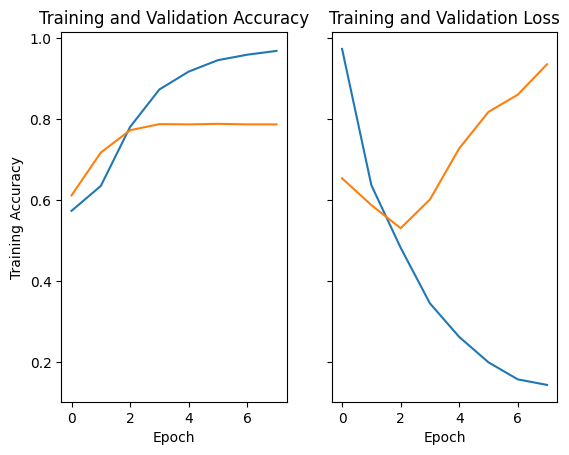

In [115]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)

axs[0].plot([i for i in range(len(history.history['accuracy']))],history.history['accuracy'])
axs[0].plot([i for i in range(len(history.history['val_accuracy']))],history.history['val_accuracy'])
axs[0].set_title('Training and Validation Accuracy')
axs[1].plot([i for i in range(len(history.history['loss']))],history.history['loss'])
axs[1].plot([i for i in range(len(history.history['val_loss']))],history.history['val_loss'])
axs[1].set_title('Training and Validation Loss')


for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Training Accuracy')

for ax in axs.flat:
    ax.label_outer()

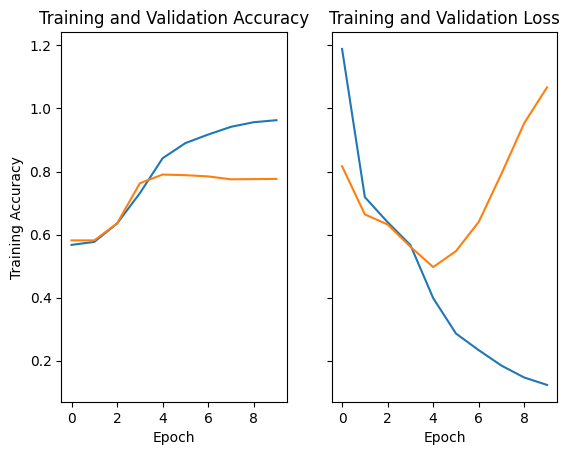

In [116]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)

axs[0].plot([i for i in range(len(history2.history['accuracy']))],history2.history['accuracy'])
axs[0].plot([i for i in range(len(history2.history['val_accuracy']))],history2.history['val_accuracy'])
axs[0].set_title('Training and Validation Accuracy')
axs[1].plot([i for i in range(len(history2.history['loss']))],history2.history['loss'])
axs[1].plot([i for i in range(len(history2.history['val_loss']))],history2.history['val_loss'])
axs[1].set_title('Training and Validation Loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Training Accuracy')

for ax in axs.flat:
    ax.label_outer()

**PREDICTIONS**

The GRU based model was used to make predictions on the testing data and the results submitted to Kaggle. The model resulted in some predictable testing performance based on the validation accuracy.

In [117]:
test_dataset = test_dataset.batch(BATCH_SIZE)

In [119]:
preds = model2.predict(test_dataset)
preds = preds.reshape(preds.shape[0], ).tolist()
yhats = [round(preds[i]) for i in range(len(preds))]
test_df["target"] = yhats
test_df = test_df[['id','target']]
print(test_df.head())
test_df.to_csv("./GRU_Preds.csv", index=False)

327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
   id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       1


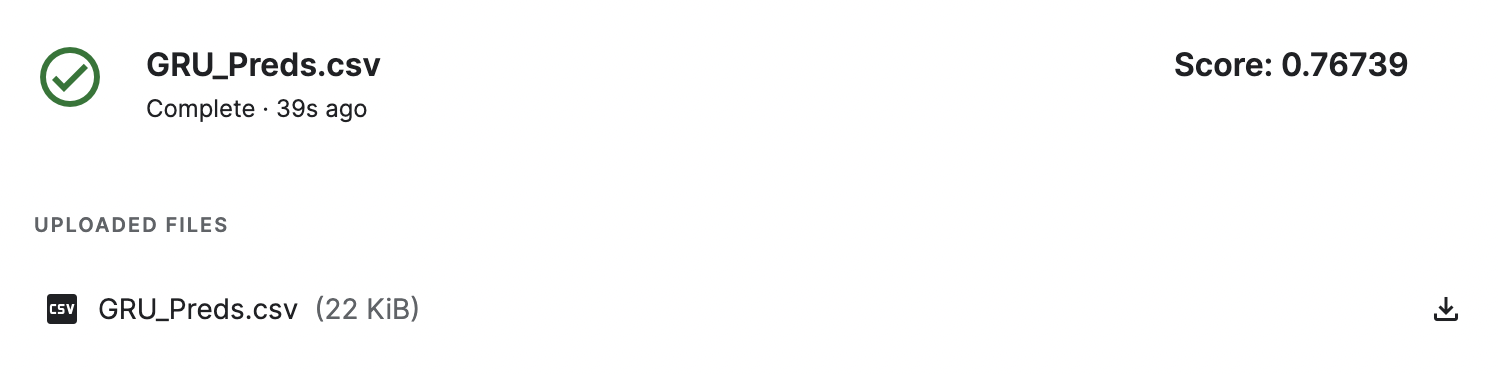